# Semantic Segmentation using nvidia/mit-b0

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from datasets import load_dataset
import json
from huggingface_hub import hf_hub_download
from transformers import AutoFeatureExtractor

## Download partial dataset to cache

In [4]:
# https://huggingface.co/docs/datasets/index
ds = load_dataset("scene_parse_150", split="train")

No config specified, defaulting to: scene_parse_150/scene_parsing


TypeError: can only concatenate str (not "int") to str

In [5]:
dataset = load_dataset("lhoestq/demo1")


Using custom data configuration lhoestq--demo1-cb69bfa340c0f55f



Extracting data files #0: 100%|██████████| 1/1 [00:00<00:00, 1041.80obj/s]


Generating train split: 0 examples [00:00, ? examples/s]

/Users/niche/miniforge3/envs/tf/lib/python3.9/site-packages/datasets/download/streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/niche/.cache/huggingface/datasets/lhoestq___csv/lhoestq--demo1-cb69bfa340c0f55f/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


/Users/niche/miniforge3/envs/tf/lib/python3.9/site-packages/datasets/download/streaming_download_manager.py:714: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
# check data type
dataset["train"]

AttributeError: 'Dataset' object has no attribute 'dtype'

In [2]:
ds.type

NameError: name 'ds' is not defined

## Insepct the 'scene_parse_150' dataset

### Overview

In [3]:
print(ds)
print(ds.info.description)

Dataset({
    features: ['image', 'annotation', 'scene_category'],
    num_rows: 50
})
Scene parsing is to segment and parse an image into different image regions associated with semantic categories, such as sky, road, person, and bed.
MIT Scene Parsing Benchmark (SceneParse150) provides a standard training and evaluation platform for the algorithms of scene parsing.
The data for this benchmark comes from ADE20K Dataset which contains more than 20K scene-centric images exhaustively annotated with objects and object parts.
Specifically, the benchmark is divided into 20K images for training, 2K images for validation, and another batch of held-out images for testing.
There are totally 150 semantic categories included for evaluation, which include stuffs like sky, road, grass, and discrete objects like person, car, bed.
Note that there are non-uniform distribution of objects occuring in the images, mimicking a more natural object occurrence in daily scene.



### Image and Label

[[[222 164 127]
  [222 164 127]]

 [[220 162 125]
  [220 162 125]]]
Shape:  (512, 768, 3)


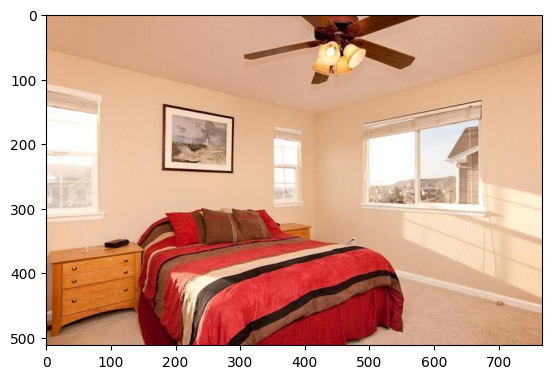

In [4]:
plt.imshow(ds[5]["image"])
print(np.array(ds[5]["image"])[:2, :2, :]) # first 2x2 pixels
print("Shape: ", np.array(ds[5]["image"]).shape)

[[6 6 6 ... 6 0 0]
 [6 6 6 ... 6 0 0]
 [6 6 6 ... 6 0 0]
 ...
 [4 4 4 ... 4 4 0]
 [4 4 4 ... 4 4 0]
 [0 0 0 ... 0 0 0]]
Shape:  (512, 768)


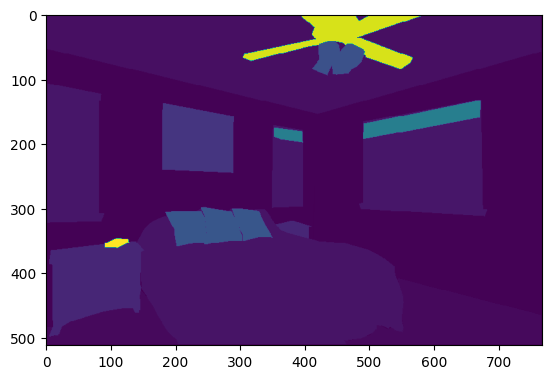

In [5]:
plt.imshow(ds[5]["annotation"])
print(np.array(ds[5]["annotation"]))
print("Shape: ",np.array(ds[5]["annotation"]).shape)

## Obtain the corresponding label map for scene_parse_150 dataset

In [6]:
# https://huggingface.co/datasets/huggingface/label-files/tree/main
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json" # was "ade20k-hf-doc-builder.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset")))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v:      k for k, v in id2label.items()}

## Feature extraction
### Extractor

In [7]:
# https://huggingface.co/docs/transformers/model_doc/segformer
# reduce_label treats the background as 255
feature_extractor = AutoFeatureExtractor.from_pretrained("nvidia/mit-b0", reduce_labels=True)
feature_extractor

SegformerFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": true,
  "resample": 2,
  "size": 512
}

### Data augmentation

In [8]:
from torchvision.transforms import ColorJitter
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)
jitter

ColorJitter(brightness=[0.75, 1.25], contrast=[0.75, 1.25], saturation=[0.75, 1.25], hue=[-0.1, 0.1])

### show the effect of jittering

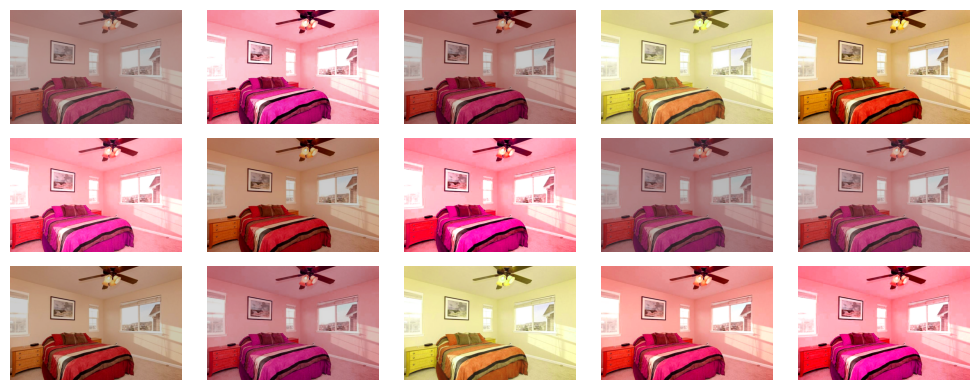

In [9]:
# multiple plots with 3 columns
fig, axs = plt.subplots(3, 5, figsize=(10, 4))
for rows in axs:
    for ax in rows:
        ax.imshow(jitter(ds[5]["image"]))
        ax.axis('off')
plt.tight_layout()
plt.show()

## Define training and validating functions
### Functions

In [10]:
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs

### Examine the results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


keys:  dict_keys(['pixel_values', 'labels'])
original shape:  (512, 768, 3)
feature shape:  (3, 512, 512)
label:  (512, 512)


(-0.5, 511.5, 511.5, -0.5)

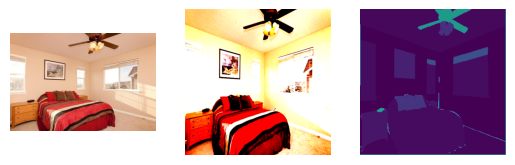

In [11]:
features = feature_extractor(ds[5]["image"], ds[5]["annotation"])
print("keys: ", features.keys())
print("original shape: ", np.array(ds[5]["image"]).shape)
print("feature shape: ", features.pixel_values[0].shape)
print("label: ", features.labels[0].shape)
fig, axs = plt.subplots(1, 3)
axs[0].imshow(ds[5]["image"])
axs[0].axis('off')
axs[1].imshow(features.pixel_values[0].swapaxes(0, 1).swapaxes(1, 2))
axs[1].axis('off')
axs[2].imshow(features.labels[0])
axs[2].axis('off')

## Split the dataset

In [12]:
ds_split = ds.train_test_split(test_size=0.2)
train_ds = ds_split["train"]
test_ds  = ds_split["test"]
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

## Construct the model mit-b0

### Define the training model

In [13]:
from transformers import AutoModelForSemanticSegmentation
pretrained_model_name = "nvidia/mit-b0"
model = AutoModelForSemanticSegmentation.from_pretrained(
    pretrained_model_name, id2label=id2label, label2id=label2id
)
from transformers import TrainingArguments
# https://huggingface.co/docs/transformers/main_classes/trainer#trainingarguments
training_args = TrainingArguments(
    output_dir="segformer-b0-scene-parse-150",
    learning_rate=6e-5,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    # move device to m1 gpu
    # latest version: pip install git+https://github.com/huggingface/transformers
    # thread: https://github.com/huggingface/transformers/issues/17971
    # use_mps_device=True,
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0

### Define the loss function

In [14]:
import evaluate
import torch
from torch import nn
metric = evaluate.load("mean_iou")
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

### Construct the model and train

In [15]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()